# Работу выполнили:
### Студенты группы М8О-208М-23:
##### *Филатова Лада*
##### *Ильин Илья*
##### *Ланин Олег*

https://github.com/mr-ilin/mai-ai-technologies/blob/main/tic_tac_toe.ipynb

Лаборатоная работа №3
Задача:
1. Обучить модель играть в игру крестики-нолики.
2. Модель должна играть на поле 3х3
3. Отобразить кривую обучения модели.

In [54]:
import numpy as np
import pickle
import random
import matplotlib.pyplot as plt
from IPython.display import clear_output

# Среда "Крестики-нолики"
class TicTacToeEnv:
    # Класс для реализации среды 'Крестики-нолики'
    PLAYER_X = 1
    PLAYER_O = 2
    EMPTY = 0

    def __init__(self, board_size=3):
        self.board_size = board_size  # Размер игрового поля
        self.reset()

    def reset(self):
        # Сбрасывает состояние игры до начального
        self.board = np.zeros((self.board_size, self.board_size), dtype=int)
        self.current_player = self.PLAYER_X
        self.move_count = 0
        return self.board.copy()

    def available_actions(self):
        # Возвращает список доступных действий (свободных клеток)
        return [(i, j) for i in range(self.board_size) for j in range(self.board_size) if self.board[i, j] == self.EMPTY]

    def step(self, action):
        # Выполняет ход и возвращает новое состояние, награду и флаг завершения игры
        row, col = action
        if self.board[row, col] != self.EMPTY:
            raise ValueError("Эта клетка уже занята!")

        # Ход текущего игрока
        self.board[row, col] = self.current_player
        self.move_count += 1

        # Проверяем победу или ничью
        if self._is_winning_move(row, col):
            return self.board.copy(), 1 if self.current_player == self.PLAYER_X else -1, True
        elif self.move_count == self.board_size ** 2:  # Ничья
            return self.board.copy(), 0, True

        # Смена игрока
        self.current_player = self.PLAYER_O if self.current_player == self.PLAYER_X else self.PLAYER_X
        return self.board.copy(), 0, False

    def _is_winning_move(self, row, col):
        # Проверяет, является ли последний ход выигрышным
        player = self.board[row, col]
        return (
            np.all(self.board[row, :] == player) or
            np.all(self.board[:, col] == player) or
            np.all(np.diag(self.board) == player) or
            np.all(np.diag(np.fliplr(self.board)) == player)
        )

    def render(self):
        # Отображает текущее состояние игрового поля
        clear_output(wait=True)
        for row in self.board:
            print(" | ".join(['X' if cell == self.PLAYER_X else 'O' if cell == self.PLAYER_O else ' ' for cell in row]))
            print('-' * (self.board_size * 4 - 1))

In [55]:
# Q-learning агент
class QLearningAgent:
    # Класс Q-learning агента
    def __init__(self, alpha=0.1, gamma=0.95, epsilon=1.0, epsilon_decay=0.999, epsilon_min=0.1):
        self.q_table = {}  # Таблица Q-значений
        self.alpha = alpha  # Скорость обучения
        self.gamma = gamma  # Коэффициент дисконтирования
        self.epsilon = epsilon  # Параметр epsilon-greedy стратегии
        self.epsilon_decay = epsilon_decay  # Скорость уменьшения epsilon
        self.epsilon_min = epsilon_min  # Минимальное значение epsilon

    def get_state_key(self, board):
        # Возвращает ключ состояния для Q-таблицы
        return tuple(board.flatten())

    def choose_action(self, state, available_actions):
        # Выбирает действие с использованием epsilon-greedy стратегии
        if random.random() < self.epsilon:
            return random.choice(available_actions)  # Случайный выбор (исследование)
        q_values = [self.q_table.get((state, action), 0) for action in available_actions]
        max_q = max(q_values)
        return random.choice([action for action, q in zip(available_actions, q_values) if q == max_q])  # Лучшее действие

    def update_q_table(self, state, action, reward, next_state, done, available_actions_next):
        # Обновляет Q-таблицу на основе опыта
        state_key = self.get_state_key(state)
        next_state_key = self.get_state_key(next_state)
        current_q = self.q_table.get((state_key, action), 0)

        if done:
            target = reward
        else:
            next_q_values = [self.q_table.get((next_state_key, a), 0) for a in available_actions_next]
            target = reward + self.gamma * max(next_q_values, default=0)

        self.q_table[(state_key, action)] = current_q + self.alpha * (target - current_q)

    def save_q_table(self, filename='q_table.pkl'):
        # Сохраняет Q-таблицу в файл
        with open(filename, 'wb') as f:
            pickle.dump(self.q_table, f)

    def load_q_table(self, filename='q_table.pkl'):
        # Загружает Q-таблицу из файла
        with open(filename, 'rb') as f:
            self.q_table = pickle.load(f)


In [56]:
# Тренировка агента
def train_agent(episodes=15000):
    # Обучает агента на заданном числе эпизодов
    agent = QLearningAgent()
    env = TicTacToeEnv()
    win_history = []

    for episode in range(episodes):
        state = env.reset()
        done = False

        while not done:
            available_actions = env.available_actions()
            action = agent.choose_action(agent.get_state_key(state), available_actions)
            next_state, reward, done = env.step(action)

            available_actions_next = env.available_actions()
            agent.update_q_table(state, action, reward, next_state, done, available_actions_next)

            state = next_state

        # Уменьшаем epsilon
        if agent.epsilon > agent.epsilon_min:
            agent.epsilon *= agent.epsilon_decay

        win_history.append(reward)

    agent.save_q_table()
    return agent, win_history


In [57]:
# Построение кривой обучения
def plot_learning_curve(win_history, window_size=100):
    """Строит график обучения агента."""
    smoothed = np.convolve(win_history, np.ones(window_size) / window_size, mode='valid')
    plt.figure(figsize=(10, 6))
    plt.plot(smoothed, label='Скользящее среднее выигрышей', color='blue')
    plt.title('Кривая обучения агента')
    plt.xlabel("Эпизоды")
    plt.ylabel("Средний результат (1 - победа, 0 - ничья, -1 - поражение)")
    plt.grid(alpha=0.3)
    plt.legend()
    plt.show()


In [59]:
# Основной блок
if __name__ == "__main__":
    print("Обучение агента...")
    agent, win_history = train_agent()
    plot_learning_curve(win_history)

    print("Запуск игры...")
    env = TicTacToeEnv()
    env.reset()

    while True:
        try:
            env.render()
            print("Ход игрока 1 (X)")
            row = int(input("Введите номер строки (1-3): ")) - 1
            col = int(input("Введите номер столбца (1-3): ")) - 1
            _, reward, done = env.step((row, col))

            if done:
                env.render()
                if reward == 1:
                    print("Поздравляем, вы победили!")
                elif reward == 0:
                    print("Ничья!")
                break

            print("Ход игрока 2 (O) - Агент")
            state = env.board.copy()
            action = agent.choose_action(agent.get_state_key(state), env.available_actions())
            _, reward, done = env.step(action)

            if done:
                env.render()
                if reward == -1:
                    print("Агент победил!")
                elif reward == 0:
                    print("Ничья!")
                break
        except ValueError:
            print("Некорректный ход. Попробуйте снова.")

X |   | X
-----------
  | X |  
-----------
O | O | O
-----------
Агент победил!


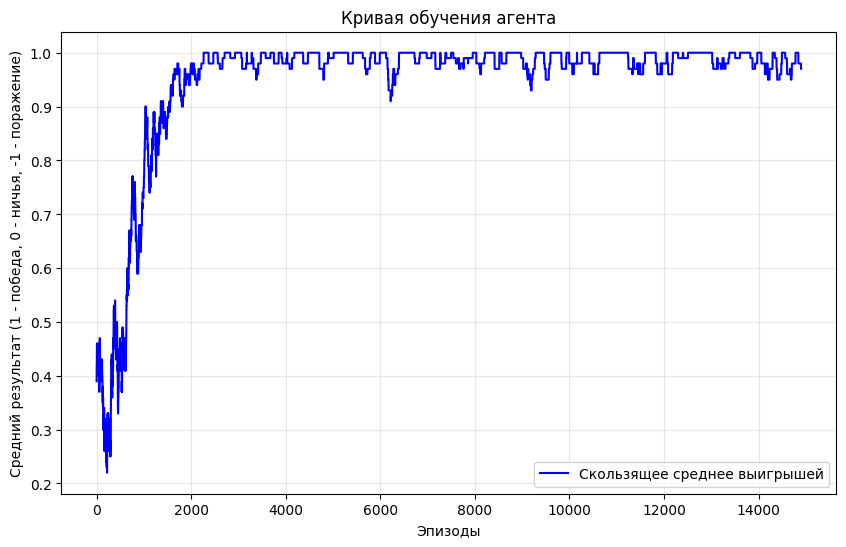

In [60]:
import matplotlib.pyplot as plt
import numpy as np

def plot_learning_curve(win_history, window_size=100):

    #Строит график обучения агента с использованием скользящего среднего

    # Вычисляем скользящее среднее
    smoothed_rewards = np.convolve(win_history, np.ones(window_size) / window_size, mode='valid')

    # Строим график
    plt.figure(figsize=(10, 6))
    plt.plot(smoothed_rewards, label='Скользящее среднее выигрышей', color='blue')
    plt.title('Кривая обучения агента')
    plt.xlabel('Эпизоды')
    plt.ylabel('Средний результат (1 - победа, 0 - ничья, -1 - поражение)')
    plt.grid(alpha=0.3)
    plt.legend()
    plt.show()

agent, win_history = train_agent(episodes=15000)
plot_learning_curve(win_history)
